In [ ]:
import tensorflow as tf
import json
import os
from distutils.dir_util import copy_tree
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# now import TensorFlow and tf.keras

from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import applications
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0 #EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import EfficientNetB0 #EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
print('TensorFlow version is: ', tf.__version__)



TensorFlow version is:  2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/MyDrive/Hackathon/DLHackathonFiles/DLHack_RFNN.zip' 'DLHack_RFNN.zip'

cp: cannot stat '/content/gdrive/MyDrive/Hackathon/Hack_NN.zip': No such file or directory


In [ ]:
!unzip -q DLHack_RFNN.zip

unzip:  cannot find or open Hack_NN.zip, Hack_NN.zip.zip or Hack_NN.zip.ZIP.


In [ ]:
dataset_path = '/content/DLHack_RFNN/dataset/'
input_size = 224
batch_size_num = 32
train_path = os.path.join(dataset_path,'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

FileNotFoundError: ignored

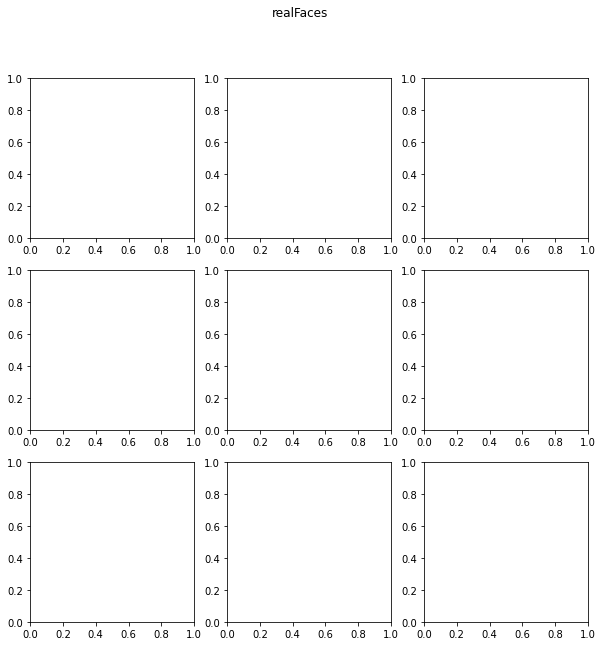

In [ ]:
def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(15,15))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(dataset_path, 'real').show()

In [ ]:
plot_img(dataset_path, 'fake').show()

In [ ]:
#Read training and test Dataframe
train_data = pd.read_csv('/content/DLHack_RFNN/train.csv')
train_data.tail()

In [ ]:
test_data = pd.read_csv('/content/DLHack_RFNN/test.csv')
test_data.head()

In [ ]:
paths = []
classes = []
for i in train_data['file_id']:
    if train_data.iloc[i]['label'] == 0:
        cls = 'fake'
    else:
        cls = 'real'
    path = dataset_path + 'train/' + cls + '/' + str(train_data.iloc[i]['file_id'])+'.jpg'
    paths.append(path)
    classes.append(cls)

train_data['file_path'] = paths
train_data['class'] = classes
train_data.head()

In [ ]:
paths = []
for i in test_data['file_id']:
    path = dataset_path + 'test/' + str(test_data.iloc[i]['file_id'])+'.jpg'
    paths.append(path)

test_data['file_path'] = paths
test_data.tail()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=1)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,    #rescale the tensor values to [0,1]
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range=0.2,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path', #File path for image
    y_col='class',   #Class for the image,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True
    #save_to_dir = tmp_debug_path
)

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path', #File path for image
    y_col='class',   #Class for the image,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True
    #save_to_dir = tmp_debug_path
)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='file_path', #File path for image
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

In [ ]:
# Train a CNN classifier
efficient_net = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (input_size, input_size, 3),
    include_top = False,
    pooling = 'max'
)
efficient_net.summary()

In [ ]:
efficient_net.trainable = False

In [ ]:
model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 256, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()

In [ ]:
# Compile model
model.compile(optimizer = Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.4),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/Hackathon/DLHackathonFiles/'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

custom_callbacks = [
    EarlyStopping(
        monitor = 'val_accuracy',
        mode = 'max',
        patience = 100,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'best_model.h5'),
        monitor = 'val_accuracy',
        mode = 'max',
        verbose = 1,
        save_best_only = True
    )
]


In [ ]:
# Train network
num_epochs = 150
history = spoofnet.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)
print(history.history)

In [ ]:
# Plot results
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# load the saved model that is considered the best
best_model = load_model(os.path.join(checkpoint_filepath, 'best_model.h5'))

# Generate predictions
test_generator.reset()

preds = best_model.predict(
    test_generator,
    verbose = 1
)

test_results = pd.DataFrame({
    "file_id": test_generator.filenames,
    "pred": preds.flatten()
})


print(test_results)

In [ ]:
print(test_results['pred'][42])

In [ ]:
submission = pd.read_csv('/content/DLHack_RFNN/test.csv')
submission['label'] =  test_results['pred'].apply(lambda score : 1 if score > 0.8 else 0)
submission.to_csv("/content/gdrive/MyDrive/Hackathon/DLHackathonFiles/SubRealFake_1.csv",index=False)
submission.head(100)